In [ ]:
import numpy as np
import pandas as pd

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
import time
import copy
from random import shuffle

import tqdm.notebook as tqdm

import sklearn
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report
from PIL import Image
import cv2

import os
import shutil

In [ ]:
covid_path = '/content/drive/MyDrive/Covid19_Minor_Project/CovidDataset/Train/Covid'
normal_path = '/content/drive/MyDrive/Covid19_Minor_Project/CovidDataset/Train/Normal'

In [ ]:
data_path = '/content/drive/MyDrive/Covid19_Minor_Project/CovidDataset'

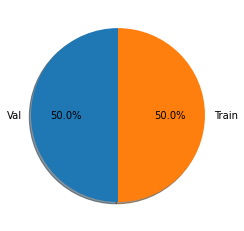

In [ ]:
class_names = os.listdir(data_path)
image_count = {}
for i in class_names:
    image_count[i] = len(os.listdir(os.path.join(data_path,i)))

#Plotting Distribution of Each Classes
fig1, ax1 = plt.subplots()
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow=True,
        autopct = '%1.1f%%',
        startangle=90)
plt.show()

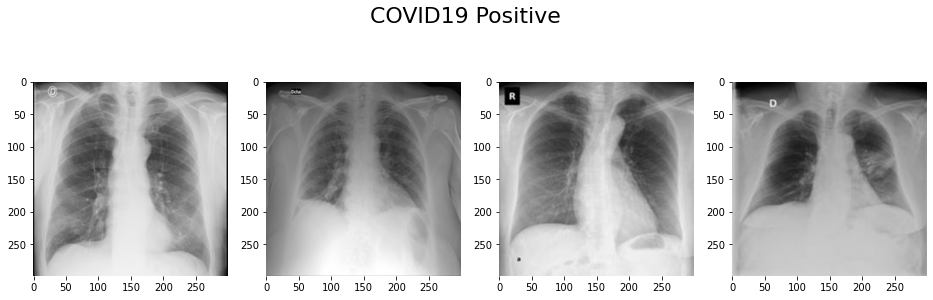

In [ ]:
fig = plt.figure(figsize=(16,5))
fig.suptitle("COVID19 Positive", size=22)
img_paths = os.listdir(covid_path)
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join(covid_path, image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
fig.show()

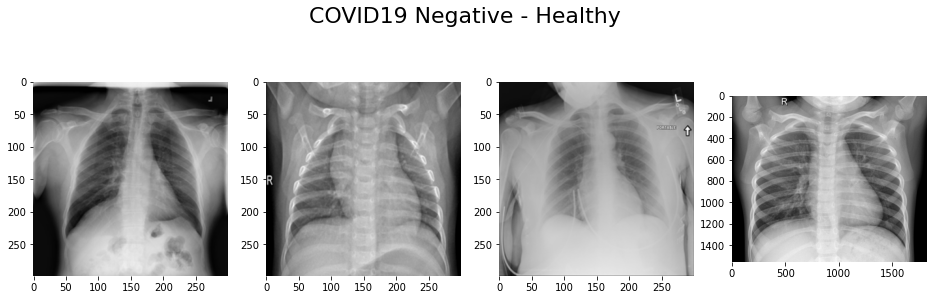

In [ ]:
fig = plt.figure(figsize=(16,5))
fig.suptitle("COVID19 Negative - Healthy", size=22)
img_paths = os.listdir(normal_path)
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join(normal_path, image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
fig.show()

In [ ]:
train_path='/content/drive/MyDrive/Covid19_Minor_Project/CovidDataset/Train'
val_path='/content/drive/MyDrive/Covid19_Minor_Project/CovidDataset/Val'

In [ ]:
data_transforms = {
    'Train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomResizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [ ]:
def load_split_train_test(datadir, valid_size = .2):
    train_data = datasets.ImageFolder(datadir,       
                    transform=data_transforms['Train']) #Picks up Image Paths from its respective folders and label them
    val_data = datasets.ImageFolder(datadir,
                    transform=data_transforms['Val'])
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    train_idx, val_idx = indices[split:], indices[:split]
    dataset_size = {"train":len(train_idx), "val":len(val_idx)}
    train_sampler = SubsetRandomSampler(train_idx) # Sampler for splitting train and val images
    val_sampler = SubsetRandomSampler(val_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=8) # DataLoader provides data from traininng and validation in batches
    valloader = torch.utils.data.DataLoader(val_data,
                   sampler=test_sampler, batch_size=8)
    return trainloader, valloader, dataset_size
trainloader, valloader, dataset_size = load_split_train_test(data_path, .2)
dataloaders = {"Train":trainloader, "Val":valloader}
data_sizes = {x: len(dataloaders[x].sampler) for x in ['Train','Val']}
class_names = trainloader.dataset.classes


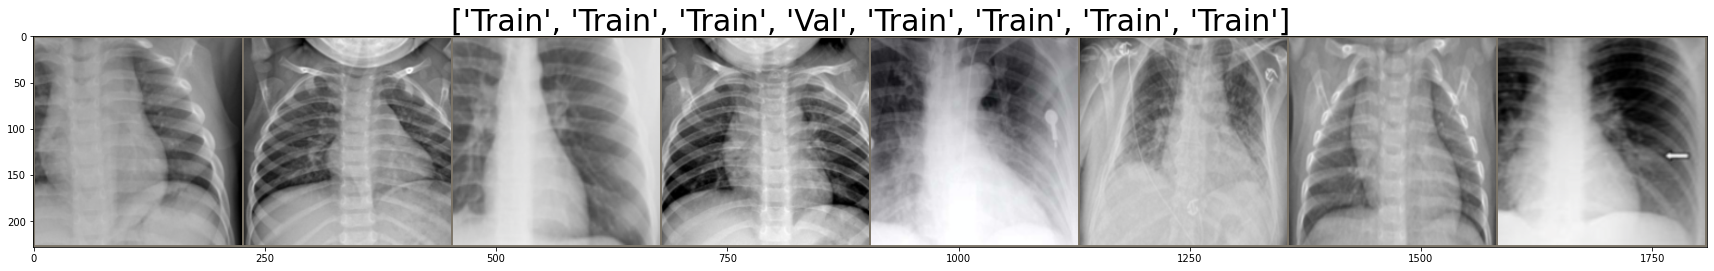

In [ ]:
def imshow(inp, size =(30,30), title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=size)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, size=30)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['Train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
if torch.cuda.is_available():
    device=torch.device("cuda:0")
    print("Training on GPU... Ready for HyperJump...")
else:
    device = torch.device("cpu")
    print("Training on CPU... May the force be with you...")

Training on GPU... Ready for HyperJump...


In [ ]:
torch.cuda.empty_cache()

In [ ]:
def CNN_Model(pretrained=True):
    model = torchvision.models.resnet18(pretrained=pretrained) # Returns Defined Resnet model with weights trained on ImageNet
    num_ftrs = model.fc.in_features # Get the number of features output from CNN layer
    model.fc = nn.Linear(num_ftrs, len(class_names)) # Overwrites the Classifier layer with custom defined layer for transfer learning
    model = model.to(device) # Transfer the Model to GPU if available
    return model

model = CNN_Model(pretrained=True)

# specify loss function (categorical cross-entropy loss)
criterion = nn.CrossEntropyLoss() 

# Specify optimizer which performs Gradient Descent
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) # Learning Scheduler

In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
11177538


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Train', 'Val']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0
            current_kappa = 0
            val_kappa = list()

            for inputs, labels in tqdm.tqdm(dataloaders[phase], desc=phase, leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients in the Cache.
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()
                if phase == 'Train':
                    scheduler.step()

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)
                val_kappa.append(cohen_kappa_score(preds.cpu().numpy(), labels.data.cpu().numpy()))
            epoch_loss = current_loss / data_sizes[phase]
            epoch_acc = current_corrects.double() / data_sizes[phase]
            if phase == 'Val':
                epoch_kappa = np.mean(val_kappa)
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f} | Kappa Score: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc, epoch_kappa))
            else:
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc))

            # EARLY STOPPING
            if phase == 'Val' and epoch_loss < best_loss:
                print('Val loss Decreased from {:.4f} to {:.4f} \nSaving Weights... '.format(best_loss, epoch_loss))
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val loss: {:.4f}'.format(best_loss))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    ax = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['Val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
    
            for j in range(inputs.size()[0]):
                images_handeled += 1    
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('Actual: {} predicted: {}'.format(class_names[labels[j].item()],class_names[preds[j]]))
                imshow(inputs.cpu().data[j], (5,5))

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
base_model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

Epoch 1/10
----------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:604: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


Train Loss: 0.8630 | Train Accuracy: 0.7134


Val Loss: 0.9268 | Val Accuracy: 0.5902 | Kappa Score: 0.0165
Val loss Decreased from inf to 0.9268 
Saving Weights... 

Epoch 2/10
----------


Train Loss: 0.6859 | Train Accuracy: 0.7683


Val Loss: 1.0070 | Val Accuracy: 0.5574 | Kappa Score: nan

Epoch 3/10
----------


Train Loss: 0.7369 | Train Accuracy: 0.7439


Val Loss: 1.0652 | Val Accuracy: 0.5410 | Kappa Score: -0.0363

Epoch 4/10
----------


Train Loss: 0.7366 | Train Accuracy: 0.7520


Val Loss: 0.9519 | Val Accuracy: 0.5820 | Kappa Score: nan

Epoch 5/10
----------


Train Loss: 0.6738 | Train Accuracy: 0.7663


Val Loss: 0.9538 | Val Accuracy: 0.6066 | Kappa Score: 0.0335

Epoch 6/10
----------


Train Loss: 0.7251 | Train Accuracy: 0.7398


Val Loss: 0.9672 | Val Accuracy: 0.5574 | Kappa Score: -0.0415

Epoch 7/10
----------


Train Loss: 0.7479 | Train Accuracy: 0.7236


Val Loss: 0.9781 | Val Accuracy: 0.5738 | Kappa Score: -0.0362

Epoch 8/10
----------


Train Loss: 0.7314 | Train Accuracy: 0.7317


Val Loss: 0.9533 | Val Accuracy: 0.5902 | Kappa Score: 0.0210

Epoch 9/10
----------


Train Loss: 0.6826 | Train Accuracy: 0.7561


Val Loss: 1.0274 | Val Accuracy: 0.5656 | Kappa Score: -0.0111

Epoch 10/10
----------


Train Loss: 0.7392 | Train Accuracy: 0.7378


Val Loss: 1.0394 | Val Accuracy: 0.5410 | Kappa Score: -0.0338

Training complete in 3m 41s
Best val loss: 0.9268


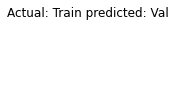

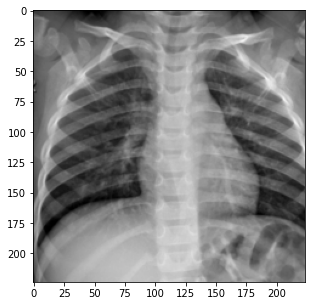

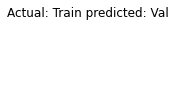

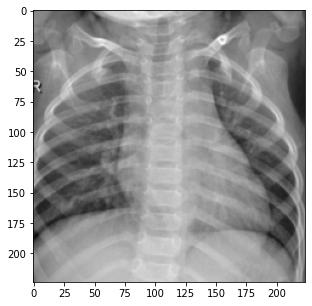

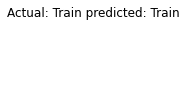

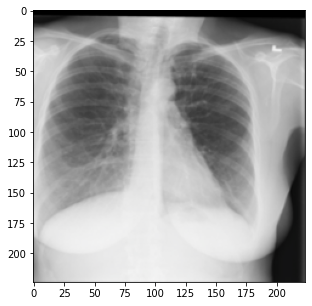

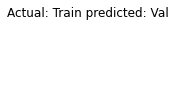

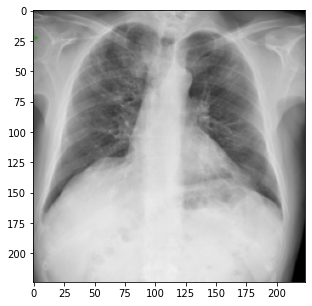

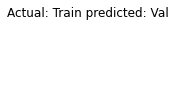

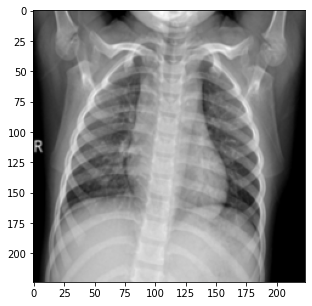

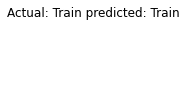

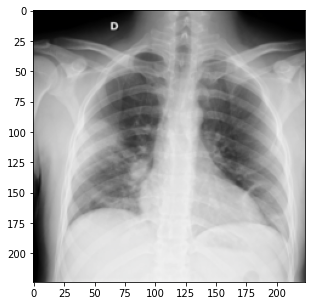

In [ ]:
visualize_model(base_model)
plt.show()

In [ ]:
test_data_path = '/content/drive/MyDrive/Copy_Final_Project/Dataset/Test'

test_transforms = transforms.Compose([
                                      transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


test_image = datasets.ImageFolder(test_data_path, transform=test_transforms)

testloader = torch.utils.data.DataLoader(test_image, batch_size=1)

In [ ]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm.tqdm(testloader, leave=False):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = base_model(x_batch)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

In [ ]:
y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

In [ ]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.69      0.75      0.72       259
           1       0.71      0.66      0.68       250

    accuracy                           0.70       509
   macro avg       0.70      0.70      0.70       509
weighted avg       0.70      0.70      0.70       509



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.show()

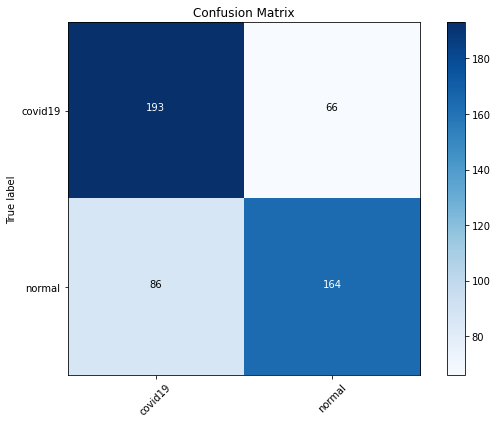

In [ ]:
from sklearn.metrics import confusion_matrix

cm =  confusion_matrix(y_true_list, y_pred_list)

plot_confusion_matrix(cm = cm, 
                      normalize    = False,
                      target_names = ['covid19','normal'],
                      title        = "Confusion Matrix")

In [ ]:
TP = cm[1][1]
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
print("Precision =",precision_score(y_true_list,y_pred_list))
print("Recall =",recall_score(y_true_list,y_pred_list))
print("F1 Score =",f1_score(y_true_list,y_pred_list))
print("Accuracy Score =",accuracy_score(y_true_list,y_pred_list))


Precision = 0.7130434782608696
Recall = 0.656
F1 Score = 0.6833333333333333
Accuracy Score = 0.7013752455795678


In [ ]:
# calculate the specificity
conf_specificity = (TN / float(TN + FP))
print("Specificity = ",conf_specificity)

Specificity =  0.7451737451737451


In [ ]:
torch.save(base_model.state_dict(), 'best_model.pth')